# NOI: Zufallsprozesse und Quantisierung im Frequenzbereich #
## DFT von Breitbandsignalen ##

In diesem Notebook soll ein sinusförmiges Signal quantisiert werden und Signal und Quantisierungsrauschen gemeinsam mit einer DFT analysiert werden. Ziel ist es, aus dem Spektrum Signal- und Rauschleistung zu ermitteln und daraus das Signal-to-Quantization Noise Ratio (SQNR). 

Hierfür müssen das Signal und das breitbandige Quantisierungsrauschen jeweils korrekt skaliert werden.

In [13]:
import os, sys

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

import dsp_fpga_lib as dsp # import and set plot properties
import dsp_fpga_fix_lib as fx

import numpy as np
import numpy.random as rnd
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange,
                    linspace, array, zeros, ones)
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, title, clf, xlim, ylim)
print(plt.style.available)
plt.style.use('seaborn-poster') # sucht in stylelib Directories
#plt.style.use('../presentation.mplstyle') # sucht im Pfad

figsize = {"figsize":(12,8)}

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test', 'presentation_style', 'presentation_svg']


## Signale
Wir generieren uns einen Ausschnitt aus einem sinusförmigen Testsignal, das eine ganzzahlige Anzahl von Perioden enthält, damit wir später ohne Fehler die DFT des quantisierten Signals bestimmen können. Wenn das ursprüngliche Signal periodisch war, ist auch das quantisierte Signal periodisch.

Aus diesem Grund sollte man darauf achten, dass das quantisierte Signal nicht "zu periodisch ist": Wenn z.B. $T_{mess} = 16 T_{sig} = 1024 T_S$ ist, könnte man das Messfenster genausogut auf $T_{mess} = T_{sig} = 64 T_S$ verkürzen, da sich das Signal (und auch das quantisierte Signal!) bereits nach 64 Samples exakt wieder holt. Damit wird das Quantisierungsrauschen auf nur 64 anstatt auf 1024 Frequenzbins aufgeteilt, man kann Nicht-Idealitäten bei der Quantisierung (z.B. Nichtlinearitäten eines ADCs) nicht mehr erkennen.

Aus diesem Grund sollte man die Frequenz von Testsignalen so wählen, dass die Anzahl der Perioden im Messfenster eine Primzahl ist (z.B. $L = 17$ anstatt 16 im obigen Beispiel). Die resultierende Frequenz ist dann $f_{sig} = L/T_{mess} = L f_S / N_{DFT}$.

In [14]:
N_FFT = 2048    # Anzahl Datenpunkte für FFT 
f_S = 2048       # Abtastfrequenz (eigentlich beliebig, ergibt Skalierungsfaktor)
f_S_Print = 50   # Abtastfrequenz für Plot
unit = ""
Ts = 1 / f_S    # Abtastperiode
t = arange(N_FFT) * Ts # Zeitvektor 0 ... (Nx-1) Ts
#f = [0:1:L-1] / N_FFT * f_S # Frequenzvektor 0 ... f_S in N_FFT Schritten
#f = f_S/2*np.linspace(0,1,N_FFT/2) # Frequenzvektor 0 ... f_S/2 in N_FFT/2 Schritten

# Definiere und instanziiere Quantizer:
q_adc = {'WI':1, 'WF':15, 'quant':'round', 'ovfl': 'sat'}
fx_adc = fx.Fixed(q_adc)

#########################################################################
# Vorbelegen der Vektoren mit Nullen zur Initialisierung und Beschleunigung
x  = zeros(N_FFT) # Eingangssignal
xq = zeros(N_FFT) #   "  (quantisiert durch ADC)

#########################################################################
# Definiere Testsignal für eine kohärente DFT ohne Leckeffekt 
N_per = 53 # Anzahl der Perioden des Signals im DFT-Rechteckfenster (mögl. prim)
a_sig = 1  # Signalamplitude
fsig = f_S * N_per / N_FFT
x = a_sig * sin(2*pi*t*fsig+1) #Testsignal mit Startphase
#x = a_sig * sin(2*pi*t*fsig+1) + 0.001*sin(2*pi*t*251) #Two-Tone Testsignal

### Input Quantization (ADC, q_adc)
### add uniform dithering noise, -1/4 LSB < eps_N < 1/4 LSB
#x += 2**(-q_adc['WF']-2)*np.random.rand(len(x))

xq = fx_adc.fixp(x) # quantisiere

if fx_adc.N_over: 
    print('Anzahl der Überläufe = ', fx_adc.N_over) 

Als nächstes berechnen wir die spektrale Leistungsdichte des quantisierten Signals, indem wir:

- den Absolutwert der DFT des Signals berechnen und mit 1/N_DFT skalieren.
- mit zwei multiplizieren, um korrekte Amplitudenwerte bei einseitiger Spektraldarstellung zu bekommen
- durch $\sqrt{2}$ dividieren, um Effektivwerte zu erhalten
- die DFT elementweise quadrieren, um die Leistung und ggf. über 10 log() die dB-Darstellung zu erhalten

Die dB-Werte entsprechen der Leistung in dBW und dem Effektivwert in dBV!

Die Gesamtleistung des Signals bekommt man im Frequenzbereich durch Summation über das gesamte (einseitige oder zweiseitige) Spektrum. Ist man nur an der Rauschleistung interessiert, müssen die Signalbins zu Null (oder, pingeliger, auf den Mittelwert der Rauschleistung) gesetzt werden.

In [15]:
#################################################################
#
# FFT über N_FFT Datenpunkte skaliert mit 1/N_FFT über Freq. von 0 ... f_S
#
# Um korrekte Amplituden bei einseitiger Darstellung (0 ... f_S/2 anstatt 
# -f_S/2 ... f_S/2) zu erhalten, werden die Spektralwerte verdoppelt:
Yq = 2 * abs(np.fft.fft(xq[0:N_FFT], N_FFT))/ N_FFT # Amplituden
Yq_eff = Yq / sqrt(2) # Effektivwerte

f = np.fft.fftfreq(N_FFT, d = 1./f_S)[0:N_FFT//2] # DFT Frequenzen 0 ... f_S/2
k = np.arange(N_FFT/2) # DFT Index
#------------------------------------------------------------------
# 
Yq_sig = Yq_eff[N_per]     # Eff.Wert des quantisierten Testsignals
PSigQ = Yq_sig ** 2        # Leistung des quantisierten Testsignals
Yq_sig_dB = 10 * log10(PSigQ) # " in dB

PSig = a_sig ** 2 / 2 # Leistung des Testsignals
PSig_dB = 10*log10(PSig)
#
Yq_dc = Yq[0]/2.               # DC-Wert des Ausgangssignals (für Debugging)
Yq_dc_dB = 20 * log10(Yq_dc)   # " in dB

# Überspringe Signalamplitude bei Berechnung der mittleren Rauschleistung / bin
Pq_avg = (np.sum(Yq_eff[0:N_per] ** 2) + np.sum(Yq_eff[N_per+1:N_FFT//2] ** 2)) / (N_FFT//2-1)
Pq_avg_dB = 10 * log10(Pq_avg)

Yq_eff[N_per] = np.sqrt(Pq_avg)
#Yq[N_per] = 0	# oder ersetze einfach durch Null

# Gesamtrauschleistung im Frequenzband von 0 ... f_S/2: e_N = Integral (Yq^2):
# Diskrete Frequenzbänder: Integral -> Summe P = SUM A_eff^2(i)

e_N = np.inner(Yq_eff[0:N_FFT//2], Yq_eff[0:N_FFT//2])
#e_N = Pq_avg * (N_FFT/2 -1)
SNR = 10 * log10(PSig / e_N) 
ENOB = (SNR - 1.7609)/6.0206

D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


D:\Programme\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


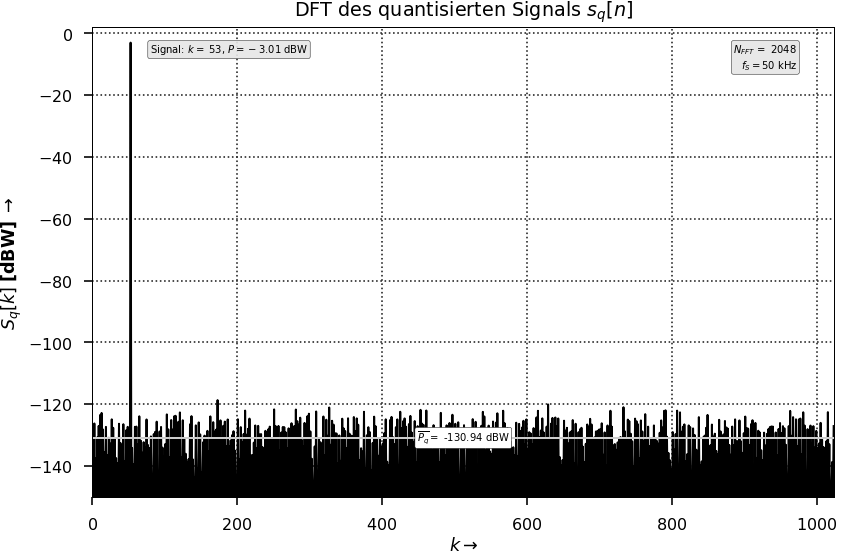

In [16]:
###############################################################################
#
# Grafische Darstellung
#
###############################################################################
TWIN_AX = False # Drucke zweite Achse für Rauschleistung
PRINT_AVG = True
PRINT_SNR = False # Drucke SNR und ENOB
PRINT_NOISE = False # Drucke Rauschleistung

Hmin = -150 # Min. y-Wert (dB) für Anzeige und Ersetzen von -infinity Werten
Hmax = 2    # Max. y-Wert (dB) für Anzeige

fig4 = plt.figure(1, **figsize)
ax4 = fig4.add_subplot(111)
ax4.set_xlim([0, f_S/2])
ax4.set_ylim([Hmin, Hmax])

# Rekonstruiere Signalamplitude:
Yq_eff[N_per] = Yq_sig
# Logarithmische Darstellung des Quantisierungsrauschens
# log(0) = -Infinity muss vor Plot durch Hmin ersetzt werden:
Yq_eff_dB = np.maximum(20 * log10(Yq_eff), np.ones(len(Yq_eff))*Hmin) 

#
# Quantisierungsrauschen
ax4.plot(f, Yq_eff_dB[0:N_FFT//2],'k',linewidth = 2, label = r'$N_Q(f)$')
# mittlere Rauschleistung
ax4.plot([0, f_S/2] , [Pq_avg_dB, Pq_avg_dB], color=(0.8,0.8,0.8), linewidth = 2,
    linestyle = '-')
    
ax4.set_title('DFT des quantisierten Signals $s_q[n]$', y=1.01)
ax4.set_ylabel(r'$S_q[k]\; \mathbf{[dBW]} \;\rightarrow$')

#
if unit == "":
    ax4.set_xlabel(r'$k \rightarrow$')
    ax4.get_xaxis().get_major_formatter().set_scientific(False)
else:
    ax4.set_xlabel(r'$f$ [%s] $\rightarrow$' %(unit))
    
ax4.grid(True)

if TWIN_AX == True:
    ax4b = ax4.twinx()
    ax4b.set_ylim(ax4.get_ylim()+ 10*log10(N_FFT/2))
    ax4b.set_ylabel(r'$N_q(f)\;  \mathbf{[dBW / bin]} \; \rightarrow$')
else:
    ax4b = ax4

if unit == "":
    ax4.text(fsig * 1.5, 10*log10(PSig),r'Signal: $k =$ %.0d, $P = %.2f$ dBW'
         %(fsig, PSig_dB), ha='left', va='top', transform = ax4.transData, 
        bbox=dict(facecolor='0.9', alpha=0.9, boxstyle="round, pad=0.2"))
else:
    pass

ax4.text(f_S/2 * 0.95, 10*log10(PSig),r'$N_{FFT}\,=$ %d' '\n' r'$f_S = %d$ kHz'
         %(N_FFT, f_S_Print), ha='right', va='top', transform = ax4.transData, 
        bbox=dict(facecolor='0.9', alpha=0.9, boxstyle="round, pad=0.2"))
        
# e_N: Gesamtrauschleistung im Frequenzband von 0 ... f_S/2: e_N = Integral (Yq^2):j
if PRINT_AVG:
    ax4b.text(f_S / 4, Pq_avg_dB,r'$\overline{P_q}=$ %.2f dBW'
       %(Pq_avg_dB), ha='center', va='center', transform = ax4b.transData, 
       bbox=dict(facecolor='1.0', alpha=1.0, boxstyle="round, pad=0.2"))

if PRINT_NOISE:
    ax4b.text(fsig * 1.5, 10*log10(e_N),r'Noise: $e_N =$ %.2e W = %.2f dBW'
       %(e_N, 10*log10(e_N)), ha='left', va='center', transform = ax4b.transData, 
       bbox=dict(facecolor='0.9', alpha=0.9, boxstyle="round, pad=0.2"))
# Textbox, positioniert an relativen- statt Datenkoordinaten (transform = ...)

if PRINT_SNR:
    ax4.text(0.97,0.02,r'SNR = %.2f dB, ENOB = %.2f bits' %(SNR, ENOB),
             ha='right', va='bottom', transform = ax4.transAxes, 
             bbox=dict(facecolor='0.8', alpha=1, boxstyle="round, pad=0.2"))
    
plt.tight_layout();

## Fragen und Experimente ##

- Interpretieren Sie das Ergebnis / die Leistungen in Zeit- und Frequenzebene
- Welches *SQNR* erwarten Sie bei den Quantisierungsparametern im Skript?
- Warum ergibt die Simulation einen schlechteren Wert? Welchen maximalen Wert können Sie erreichen?
- Legen Sie ein Sinussignal mit der halben maximalen Amplitude an den Quantisierer. Welche Signalleistung erwarten Sie, welches *SQNR* und welche *ENOB*?

- Erklären Sie, welchen Einfluss die Anzahl der dargestellten Signalperioden $N\_per$ im Code auf das dargestellte Spektrum hat. 


***
**Copyright**

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2019*.